<center>
<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars_2020/sem08/real_expect.png" width="500">

# Домашнее задание 10: Бутстрап
</center>

**ФИО:**

## Общая информация

- [Лекция](https://youtu.be/CJnorD7RF-o)
- Полезные блокноты: [Монетки,](https://github.com/hse-econ-data-science/andan2024/blob/main/sem14_bootstrap/sem14_python_bootstrap.ipynb) [симуляции](https://github.com/hse-econ-data-science/andan2024/blob/main/sem14_bootstrap/sem14_bootstrap_simulations_bonus.ipynb)

__Дата выдачи:__ 01.06.2024

__Дедлайн:__ 23:59MSK 20.06.2024

In [2]:
import numpy as np
import pandas as pd

from scipy import stats as sts

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

## Задание 1 (дискриминация)

Компания Verizon - основная региональная телекоммуникационная компания в западной части США. Она отвечает за поддержание наземной телефонной связи (Incumbent Local Exchange Carrier, ILEC). Кроме того, она продаёт услуги междугородней связи, как и ряд её конкурентов, получивших название (Competing Local Exchange Carriers, CLEC).

Когда что-то шло не так, Verizon отвечала за ремонт своего оборудования и оборудования конкурентов. Она должна была делать ремонт оборудования конкурентов также быстро, как и ремонт своего оборудования. За этим следила комиссия по коммунальным услугам.

Периодически возникали подозрения, что Verizon ремонтирует чужое оборудование медленнее. Тим Хестерберг, автор [отличной статьи про бустрап,](https://arxiv.org/pdf/1411.5279.pdf) консультировал компанию Verizon во время слушаний о нарушениях. Комиссия сравнивала время ремонта для Verizon и других компаний. Чтобы определить есть ли нарушения, в каждом случае, она проверяла гипотезу о равенстве средних на уровне значимости $1\%$.

Если более $1\%$ тестов оказывались значимыми, компания должна была бы заплатить высокий штраф. Гипотезы проверялись с помощью $t$-статистик. После консультации Тима, Verizon предложила использовать тесты, робастные к выбросам и никак не завязанные на нормальность исходных распределений.

Мы в этом задании попробуем ответить на тот же вопрос, связанный с дискриминацией, но с помощью бустрапа. Для этого мы построим доверительный интервал для разности медиан и посмотрим входит ли в него ноль. Будем использовать уровень значимости в $1\%$. Доверительный интервал будем строить для одной CLEC-комиании и для Verizon.

In [3]:
df = pd.read_csv('verizon.txt', sep='\t')
print(df.shape)

# ILEC - Verizion
# CLEC - внешние клиенты
df.head()

(1687, 2)


,Time,Group
0,17.50,ILEC
1,2.40,ILEC
2,0.00,ILEC
3,0.65,ILEC
4,22.23,ILEC


Посмотрим на то, как распределено время ремонта для разных компаний, а также на число наблюдений, которым мы располагаем.

In [4]:
df.groupby('Group')['Time'].agg(['count', 'mean', 'median', 'std'])

,count,mean,median,std
Group,,,,
CLEC,23,16.509130,14.33,19.503576
ILEC,1664,8.411611,3.59,14.690039


В данных есть существенный перекос в количестве наблюдений. Среднее время ремонта CLEC почти вдвое больше, чем для ILEC. Вопрос в том, является ли это свидетельством дискриминации. Если посмотреть на распределение, можно заметить, что распределение времени на ремонт CLEC имеет как минимум один выброс. Тем не менее, если смотреть на медианы, которые робастны (нечувствительны) к выбросам, ситуация, связанная со временем оказывается ещё более драмматичной.

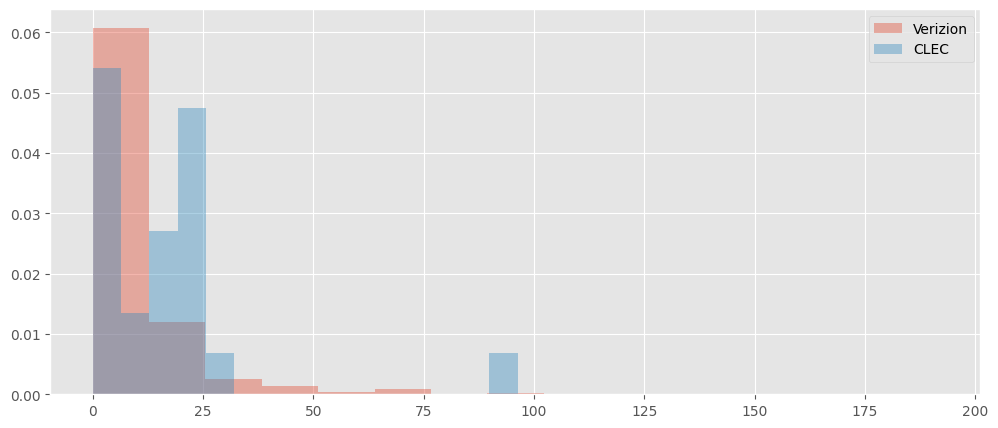

In [5]:
plt.figure(figsize=(12,5))
df[df.Group == 'ILEC'].Time.hist(bins=15, label='Verizion', alpha=0.4, density=True)
df[df.Group == 'CLEC'].Time.hist(bins=15, label='CLEC', alpha=0.4, density=True)
plt.legend();

__а) [2 балла]__ Постройте для разницы $med_{CLEC} - med_{Verizion}$ доверительный интервал Эфрона (перцентильный доверительный интервал).

__Решение:__ Напишем функцию для генерации бутстрапируемых выборок:

In [14]:
def get_bootstrap_sample(x, B_sample=1):
    N = x.size
    sample = np.random.choice(x, size=(N, B_sample), replace=True)

    if B_sample == 1:
        sample = sample.T[0]
    return sample

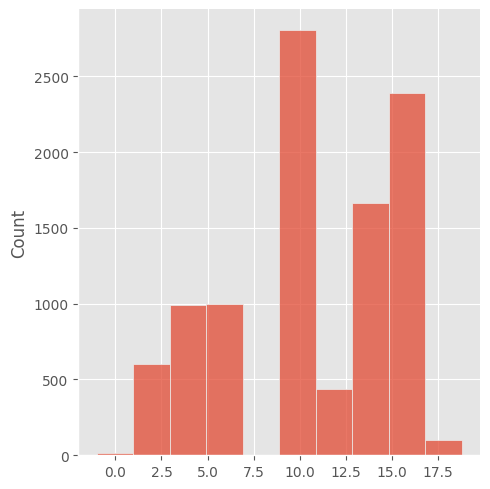

In [18]:
x = df[df['Group'] == 'ILEC']['Time'].values
y = df[df['Group'] == 'CLEC']['Time'].values

B_sample=10**4
alpha = 0.01

x_boot = get_bootstrap_sample(x, B_sample)
y_boot = get_bootstrap_sample(y, B_sample)

x_boot = np.median(x_boot, axis=0)
y_boot = np.median(y_boot, axis=0)

diff = y_boot - x_boot

sns.displot(diff, bins=10)
plt.show()

In [19]:
left = np.quantile(diff, alpha/2)
right = np.quantile(diff, 1 - alpha/2)

left, right

(np.float64(1.7200000000000002), np.float64(17.49004999999999))

In [20]:
# проверка того, что задание решено верно
assert left > 1.6
assert right < 20

# подобные тесты скрыты от вас

__Вывод:__ Ноль не попадает в доверительный интервал, следовательно действительно есть разница между средним временем ремонта на уровне статистической значимости 1%

В целом, перцентильный интервал выглядит самым простым вариантом оценивания, однако в реальности он даёт весьма плохие результаты, так как сильно зависит от того насколько хорошо изначальная выборка аппроксимирует истинное распределение случайной величины. В данной ситуации из-за того, что исходное распределение асимметрично, мы получаем смещение.

__б) [2 балла]__ Постройте для разницы $med_{CLEC} - med_{Verizion}$ доверительный интервал Холла (обратный перцентильный доверительный интервал).

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

left = ...
right = ...

# your code here


In [ ]:
# проверка того, что задание решено верно
assert left > 3
assert right < 22

# подобные тесты скрыты от вас

Холл в своей работе называл перцентильный интервал "the wrong pivot, backwards". Обратный перцентильный интервал для асимметричных распределений делает то же самое, но в обратном направлении.

__в) [2 балла]__ Постройте $t-$ перцентильный доверительный интервал:

1. Найдите точечную оценку неизвестного параметра (разность медиан) и точечную оценку стандартного отклонения
2. Сгенерируйте $10^5$ boostrap-выборок
3. Рассчитайте по каждой выбооке выборочную разницу медиан
4. Рассчитайте по каждой выборке стандартную ошибку
5. Найдите по каждой выборке $$t^* = \frac{\hat \theta^{*} - \hat{\theta}}{S^{*}}$$
6. Найдите для $t^{*}$ квантили уровня $0.05$ и $0.95$
7. Постройте доверительный интервал для разности медиан

В качестве $S^{*}$ исполизуйте сумму стандартных отклонений, посчитанных по выборкам $x$ и $y$. Конечно же, мы используем при таком подходе неправильное стандартное отклонение. При этом мы надеемся, что бутсрэп сам поправит нашу ошибку. При таком подходе главное, чтобы знаменатель сходился по вероятности к какому-нибудь пределу.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

theta_hat = ...
std_hat = ...

left = ...
right = ...

alpha = 0.01
# your code here


In [ ]:
# проверка того, что задание решено верно
assert left < 2
assert right > 20

# подобные тесты скрыты от вас

У $t$-bootstrap есть одно интересное свойство: он "уважает" асимметрию распределений при расчёте доверительных интервалов.

__г) [2 балла]__ Что в итоге? Есть ли дискриминация на рынке?

__Ответ:__

__д) [2 балла]__ Попробуйте оценить  $S^{*}$ с помощью двойного бутстрапа:

1. Бутстрапируем $B$ выборок
2. Для каждой сбутстрапированной выборки делаем ещё $B$ итераций бутстрапа, рассматривая эту выборку как исходную
3. По каждой выборке второго уровня находим асимметрию, подсчитываем по полученным асимметриям стандартное отклонение
4. Теперь у нас есть $B$ асимметрий и $B$ их стандартных отклонений
5. Стандартное отклонение, найденное по выборке асимметрий первого уровня мы будем использовать для подсчёта наблюдаемого значения статистики

Получается матрёшка из бутстрапов. Внутри каждого бутстрапа ещё $B$ бутсрапов. Изменились ли ваши выводы?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you